Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

As best I can tell, f1 and f2 never change sign for positive u and x. I'm going to try looking at the zeros of the derivatives of x and u instead

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
np.seterr(all='raise')

#AV=False
cs=1
M=10
G=1
mB=1
dPdS=1
Se=0
rho=1
T=1
r0=1

def ndf1(psi,coords):
    '''Dimensionless f1 function, takes t,(x,y) and returns 1-exp[2y]'''
    try:
        return 1-np.exp(2*coords[1])
    except:
        print("Error in ndf1 at ",psi,", ",coords)
        return -1
def absndf1(psi,coords):
    '''Absolute value of ndf1'''
    return abs(ndf1(psi,coords))

def ndf2(psi,coords):
    '''Dimensionless f2 function, takes t,(x,y) and returns (GM/r0*cs^2)exp[-x]-2'''
    try:
        return np.exp(-coords[0])*G*M/((cs**2)*r0)-2
    except:
        print("Error in ndf2 at ",psi,", ",coords)
        return -1
def absndf2(psi,coords):
    '''Absolute value of ndf2'''
    return abs(ndf2(psi,coords))

def CoupledRungeKuttaStep(af1,af2,fn,t,dt): 
    """Takes functions af1 and af2, state f(n), t and dt, and steps f(n) to f(n+dt) using an RK4 method with arbitrary input functions f1 and f2
    Returns t+dt,f(n+dt)
    
    Parameters:
        af1: function that takes (t,fn) and returns a number
        af2: function that takes (t,fn) and returns a number
        fn: numpy array (x,u)
        t: generalized time of currState
        dt: generalized time step size
        
    Returns:
        numpy array [t,[x,u]] incremented by one RK4 step"""  
    f1k1=dt*af1(t,fn)
    f2k1=dt*af2(t,fn)
    f1k2=dt*af1(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f2k2=dt*af2(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f1k3=dt*af1(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f2k3=dt*af2(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f1k4=dt*af1(t+dt,fn+np.array([f1k3,f2k3]))
    f2k4=dt*af2(t+dt,fn+np.array([f1k3,f2k3]))
    return np.array([t+dt,np.array([fn[0]+(f1k1+2*f1k2+2*f1k3+f1k4)/6,fn[1]+(f2k1+2*f2k2+2*f2k3+f2k4)/6])])

def percentChange(curr,step):
    """Takes a current state and a new state (vectors) and calculates the percent change
    
    Parameters:
        curr: numpy array (x,u)
        step: numpy array (x',u')
    
    Returns:
        Percent change from curr to step"""
    return 100*abs(np.linalg.norm((step-curr)/np.linalg.norm(curr)))

def adaptRK(currState,pc,t,dt,AV):
    """Adapts dt to ensure the change in (x,u) is between .1 and 1 percent
    This system does not always behave as expected, so the adaptation iteratively finds a new dt to correct the error
    This new dt can be either larger or smaller, independent of the initial percent change
    Takes a state (x,u), a percent change, t, dt, and absolute value (boolean)
    
    Parameters:
        currState: numpy array (x,u)
        pc: percent change between currState and the next RK step with t, dt
        t: generalized time of currState
        dt: generalized time step size
        AV: use the absolute value of f1 and f2 (boolean)
        
    Returns:
        dt, adjusted so that the percent change is between .1 and 1 percent"""
    
    ddt=1.5
    i=0
    itermax=10000
    if pc>1:
        pc2=1e10 #initialize dummy percent changes, used to track movement in % change while finding new dt
        prevpc2=1e10
        while pc2>1 and i<itermax:
            dt=dt*ddt
            if AV:
                step2=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
            else:
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt) #calculate hypothetical next step using new dt
            pc2=percentChange(currState,step2[1])
            if pc2>prevpc2: #if we're moving in the wrong direction, invert our change in dt
                ddt=1/ddt
            prevpc2=pc2
            i=i+1
        if i==itermax: print("Max iteration count exceeded in adaptation")
        return dt #once we've found a working dt, take a step using it
    elif pc<.1: 
        pc2=1e-10 #initialize dummy percent changes, used to track movement in % change while finding new dt
        prevpc2=1e-10
        while pc2<.1 and i<itermax:
            dt=dt*ddt
            if AV:
                step2=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
            else:
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt) #calculate hypothetical next step using new dt
            pc2=percentChange(currState,step2[1])
            if pc2<prevpc2: #if we're moving in the wrong direction, invert our change in dt
                ddt=1/ddt
            prevpc2=pc2
            i=i+1
        if i==itermax: print("Max iteration count exceeded in adaptation")
        return dt #once we've found a working dt, take a step using it

def generateFunc(x0,u0,itermax,AV,xrange,urange):
    """Generates a trace of wind behavior with initial conditions x0 and u0 (dimensionless) using the RK4 method with adaptation in dt
    Takes x0, u0, max iteration count and returns a 2D array tracking t, x, and u
    
    Parameters:
        x0: starting x value
        u0: starting u value
        itermax: maximum iteration count for loop
        AV: use the absolute value of f1 and f2 (boolean)
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
    
    Returns:
        numpy array, [0] contains t values, [1] contains x values, [2] contains u values for the wind curve"""
    xsol=np.array([x0])
    usol=np.array([u0])
    tarray=np.array([0])
    t=0
    dt=.01
    i=0
    currState=np.array([xsol[-1],usol[-1]])
    
    #Main loop for adaptive RK solver
    #Exit conditions are based on values for exp(x)
    #Using zero points for f1 and f2 only works if you change ndf1 and ndf2 to return absolute values, and then you don't see the full curve
    #Setting a max iteration count doesn't always work well - the solution curves may be cut
    while np.exp(currState[0])>1e-6 and np.exp(currState[0])<xrange and i<itermax: #and abs(ndf1(t,currState))>.001 and ndf2(t,currState)>.001:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        if AV:
            step=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
        else:
            step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
        
        #If the percent change is too large or too small, change dt to compensate
        if pc>1 or pc<.1:
            dt=adaptRK(currState,pc,t,dt,AV)
            if AV:
                step=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
            else:
                step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        xsol=np.append(xsol,step[1][0]) #update solution curves with next step
        usol=np.append(usol,step[1][1])
        t=t+dt
        i=i+1
        tarray=np.append(tarray,t)
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return np.array((tarray,xsol,usol))

def makePlot(u0,AV,xrange,urange):
    """Generates a plot of one wind curve
    Takes u0 and generates a curve
    Returns 0, prints a plot of the wind curve
    
    Parameters:
        u0: initial value of u
        AV: use absolute value of f1 and f2 functions (boolean)
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
        
    Returns:
        0
    
    Displays a plot of one wind curve"""
        
    plt.figure(1)
    plt.xlim(1,xrange)
    plt.ylim(0,urange)

    func=generateFunc(0,np.log(u0),10000,AV,xrange,urange)
    plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);
    return 0

def makePlots(vmin,vmax,dv,AV,xrange,urange):
    """Generates a plot of wind curves
    Takes vmin, vmax, dv and generates a curve for u0 (x0=0), then increments v0 by dv and generates a new curve, repeating until v0=umax
    Expects vmin, vmax, and dv scaled by 1/cs
    Returns 0, prints a plot of the different wind curves
    
    Parameters:
        umin: starting u value
        umax: maximum u value
        du: increment of u
        AV: Use absolute value of f1 and f2 functions (boolean)
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
    
    Returns:
        0
    
    Displays a plot of several different wind curves"""
        
    plt.figure(1)
    plt.xlim(1,xrange)
    plt.ylim(0,urange)

    for i in np.arange(vmin,vmax,dv):
        #print("\n*******iteration********* ",i,"\n")
        func=generateFunc(0,np.log(i),10000,AV,xrange,urange)
        plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);
    return 0

def findZeros(v0):
    """Finds the t values where f1 and f2 reach zero, and returns the difference
    Takes starting velocity v0, expected to be scaled by 1/cs
    Returns tu-tx
    
    Parameters:
        v0: initial value of v/cs"""
    
    u0=np.log(v0)
    xsol=np.array([0])
    usol=np.array([u0])
    t=0
    dt=.01
    currState=np.array([xsol[-1],usol[-1]])
    xfound=False
    ufound=False
    tu=0
    tx=0
    
    #Main loop, uses RK solver and iterates until f1 or f2 changes sign, and returns the t value where that takes place    
    while not ufound and not xfound:#np.exp(currState[0])>1e-6 and np.exp(currState[0])<10 and not ufound and not xfound:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
        
        #If the percent change is too large or too small, change dt to compensate
        if pc>1 or pc<.1:
            dt=adaptRK(currState,pc,t,dt,True)
            step=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
        
        #if ndf2 changes sign, we have found its turnover point and can exit the loop
        if np.sign(ndf2(t,step[1]))!=np.sign(ndf2(t,currState)):
            xfound=True
            tx=t

        #if ndf1 changes sign, we have found its turnover point and can exit the loop
        if np.sign(ndf1(t,step[1]))!=np.sign(ndf1(t,currState)):
            ufound=True
            tu=t
            
        #update solution curves with next step
        xsol=np.append(xsol,step[1][0])
        usol=np.append(usol,step[1][1])
        t=t+dt
        
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return (tu-tx)

def findVboundary(guess,dv0,maxprecision,itermax):
    """Locates the boundary value of v0 at which f1 and f2 pass through zero at the same time
    
    Parameters:
        guess: starting value of v0
        dv0: initial step size for incrementing v0
        maxprecision: sets limit on how small dv can be before exiting the loop
        itermax: maximum iteration count
    
    Returns:
        Boundary value for v0"""
    
    v0=guess
    dv=dv0
    i=0
    dt=findZeros(v0)
    
    #Main loop, while dv is larger than the max precision we want to continue refining our search
    while abs(dv)>maxprecision and i<itermax:
        
        #When we find a sign change in the zero for a given v0, that implies that the solution has changed character between a breeze and a non-physical one
        #i.e. whichever of f1 and f2 changed sign first, that has now reversed
        #when that happens, we shrink dv until we avoid the sign change, in order to approximate where exactly that occurs in v0
        while np.sign(findZeros(v0+dv))!=np.sign(findZeros(v0)):
            dv=dv/2
        v0=v0+dv
        dt=findZeros(v0)
        i=i+1
    if i>=itermax:
        print("Max iteration count exceeded")
    return v0+dv
    
def findV0(lowerguess,upperguess,dv,maxprecision,itermax,xrange,urange):
    """Finds boundary values for v0 and estimates an exact value for it
    
    Parameters:
        lowerguess: estimate of lower bound on v0/cs
        upperguess: estimate of upper bound on v0/cs
        dv: initial step size for incrementing v0/cs
        maxprecision: sets limit on how small dv can be before exiting the loop
        itermax: maximum iteration count
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
        
    Returns:
        0
    
    Prints bounds on v0, estimated value, and estimated error
    Displays plot of the wind curves for the boundary values of v0"""
    
    lower=findVboundary(lowerguess,dv,maxprecision,itermax)
    upper=findVboundary(upperguess,-dv,maxprecision,itermax)
    makePlot(lower,False,xrange,urange)
    makePlot(upper,False,xrange,urange)
    print("Lower bound on v0: ",lower)
    print("Upper bound on v0: ",upper)
    print("Estimated v0: ",(lower+upper)/2)
    print("Estimated error: ",(upper-lower)/2)
    return 0

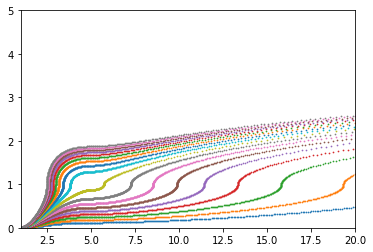

In [2]:
makePlots(.001,.01,.0005,True,20,5);

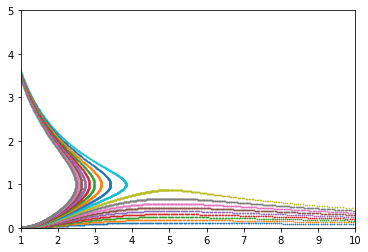

In [3]:
makePlots(.001,.01,.0005,False,10,5);

Lower bound on v0:  0.005086767017841339
Upper bound on v0:  0.005086783051490783
Estimated v0:  0.005086775034666062
Estimated error:  8.016824721863297e-09


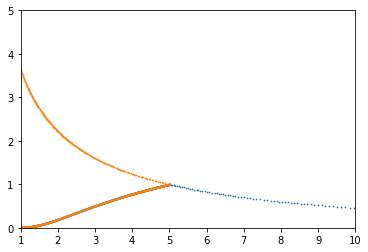

In [7]:
findV0(.004,.006,.001,1e-10,10000,10,5);

In [ ]:
#Testing the CoupledRungeKuttaStep function with a known DE
#It works as expected

def testf(t,x):
    return -3*x[0]+np.sqrt(2)*x[1]
def testf2(t,x):
    return np.sqrt(2)*x[0]-2*x[1]

def generateTestFunc(x0,y0):
    x1=np.array([x0])
    x2=np.array([y0])
    t=0
    while t<10:
        step=CoupledRungeKuttaStep(testf,testf2,np.array([x1[-1],x2[-1]]),t,.01)
        x1=np.append(x1,step[1][0])
        x2=np.append(x2,step[1][1])
        t=t+.01
        #print(xstep)
    return np.array([x1,x2])

func2=generateTestFunc(2,-1)
plt.scatter(func2[0],func2[1])

In [ ]:
import scipy.integrate as sc

def ndf1(psi,coords):
    return 1-np.exp(2*coords[1])

def ndf2(psi,coords):
    return np.exp(-coords[0])*G*M/((cs**2)*r0)-2

lambda t,y: (ndf1(t,y),ndf2(t,y))

sol=sc.solve_ivp(lambda t,y: (ndf1(t,y),ndf2(t,y)),(0,np.log(5)),(0,np.log(.001)))

In [ ]:
sol['t']

In [ ]:
sol['y']

In [ ]:
plt.scatter(np.exp(sol['y'][0]),np.exp(sol['y'][1]))